In [2]:
import sys
sys.path.insert(0, sys.path[0]+"/../")

import ENV
import BLSTM_ATT
from Step1_offlineDRL.offline_DRL.DQN import DQN
from Step1_offlineDRL.offline_DRL.PPO import PPO

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# DATA driven DRL

In [3]:
data = pd.read_csv('../Step1_offlineDRL/DATA/rdata.csv').iloc[:,1:]
index = np.load('../Step1_offlineDRL/DATA/index.npy',allow_pickle=True).tolist()
action_table = np.load('../Step1_offlineDRL/DATA/action_table1.npy',allow_pickle=True).tolist()

agent_params={
    'state_dim':len(index['state']),
    'action_dim':len(action_table),

    'encoding_layer':[50,50],
    'value_layer':[50,50],
    'advantage_layer':[50,50],
    'test_num':144, # see pretrain_data

    'train_iterations':2,
    'training_step':100,
    'gamma':0.01,
    'epsilon':0.1,
    'ep_min':1e-50,
    'ep_decay':0.9,
    'learning_rate':0.001,

    'action_table':np.array(action_table),
}

dqnmodel = DQN.DQN(agent_params)
#dqnmodel.load_model('../Step1_offlineDRL/offline_DRL/Results_DQN_reward3/model/')
dqnmodel.load_model('../Step2_dataDrivenDRL/Results_DQN_reward3/model/')
print('model done')

model done


# Simulation control process

In [4]:
selected_timepoint = [10,20,30]
sim_step, step = 10, 4*24 # 4 days

In [5]:
for timepoint in selected_timepoint:
    env = ENV.ENV()
    out = []
    results = env.reset(timepoint,step)
    for s in range(step):
        observation = np.array(data.values[env.timepoint + sim_step,env.title['state']+env.title['inflow']].tolist()).reshape((1,-1))
        a = DQN.sample_action(observation,dqnmodel,False)
        #_, a = PPO.sample_action(observation,ppomodel,False)
        action = action_table[a.numpy()[0]]
        results, done = env.step(action)
    
    #np.save('./results/'+str(timepoint)+'.npy',results)

# 作图

In [6]:
def renormlization(rangedata,rdata):
    # rangedata: numpy with same axis1
    minD, maxD = rangedata[:,0], rangedata[:,1]
    data = minD + (maxD-minD) * (rdata + 1)/2
    return data

rangedata = np.load('../Step0_DNN/DATA/rangeData.npy',allow_pickle=True).tolist()
rangedata_out = []
for k in ['出水流量','出水COD','出水TP','出水TN','出水NH3']:
    tem = [rangedata[k]['min'],rangedata[k]['max']]
    rangedata_out.append(tem)
rangedata_out = np.array(rangedata_out)

rangedata_action = []
for k in ['DO_2#A','DO_2#B','DO_3#']:
    tem = [rangedata[k]['min'],rangedata[k]['max']]
    rangedata_action.append(tem)
rangedata_action = np.array(rangedata_action)

timepoint = 20
r1 = np.load('./results/'+str(timepoint)+'.npy',allow_pickle=True).tolist()

### outflow

In [7]:
ybar = data.values[timepoint:timepoint+step,env.output_index]
yre = renormlization(rangedata_out,np.array(r1['outflow']))
ytrainre = renormlization(rangedata_out,ybar)

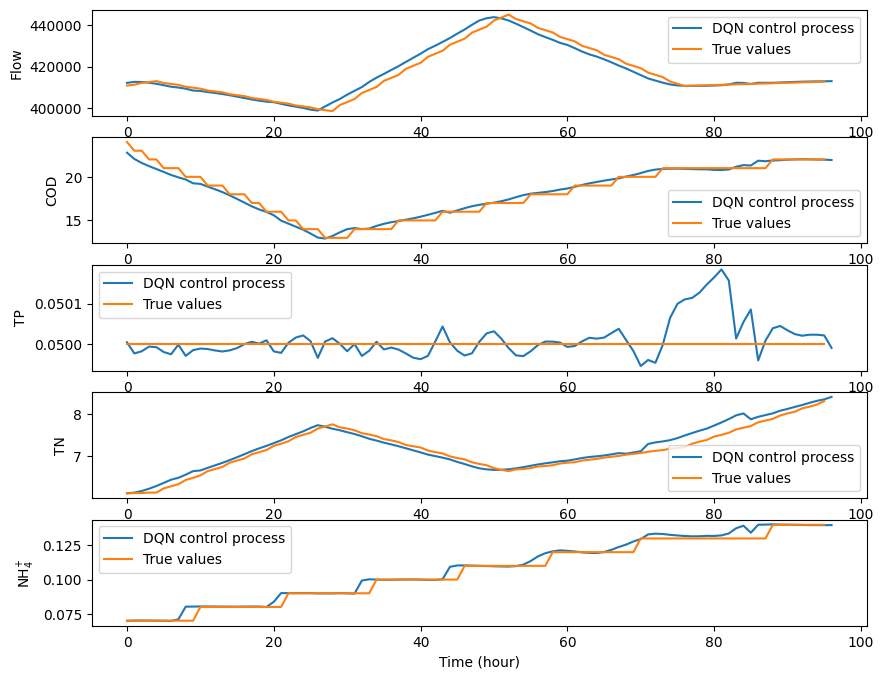

In [8]:
fig, ax = plt.subplots(5,1,figsize=(10,8))
ylbel = ['Flow','COD','TP','TN','NH'+'$_{4}^{+}$']
for i in range(5):
    ax[i].plot(yre[:,i],label='DQN control process')
    ax[i].plot(ytrainre[:,i],label='True values')
    ax[i].set_ylabel(ylbel[i])
    ax[i].set_xlabel('Time (hour)')
    ax[i].legend()


### action

In [9]:
abar = data.values[timepoint:timepoint+step,env.title['control']]
are = renormlization(rangedata_action,np.array(r1['action']))
atrainre = renormlization(rangedata_action,abar)

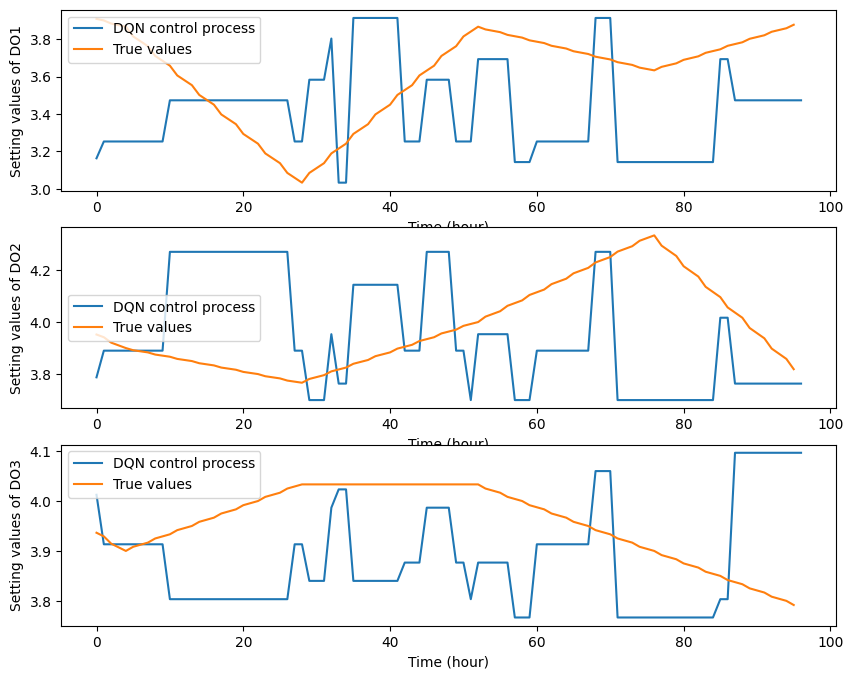

In [10]:
fig, ax = plt.subplots(3,1,figsize=(10,8))
ylbel = ['Setting values of DO1','Setting values of DO2','Setting values of DO3']
for i in range(3):
    ax[i].plot(are[:,i],label='DQN control process')
    ax[i].plot(atrainre[:,i],label='True values')
    ax[i].set_ylabel(ylbel[i])
    ax[i].set_xlabel('Time (hour)')
    ax[i].legend()


### reward

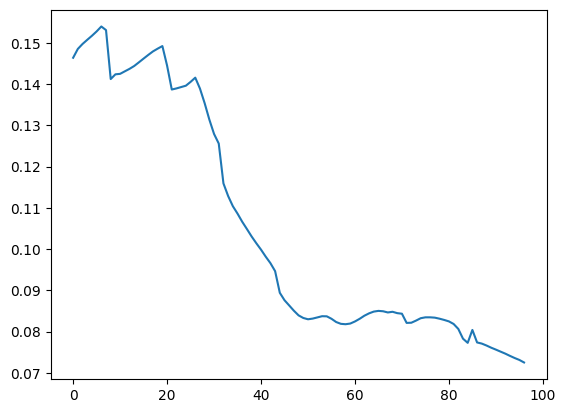

In [11]:
reward = np.array(r1['rewards'])
plt.plot(reward)

## 合并图片

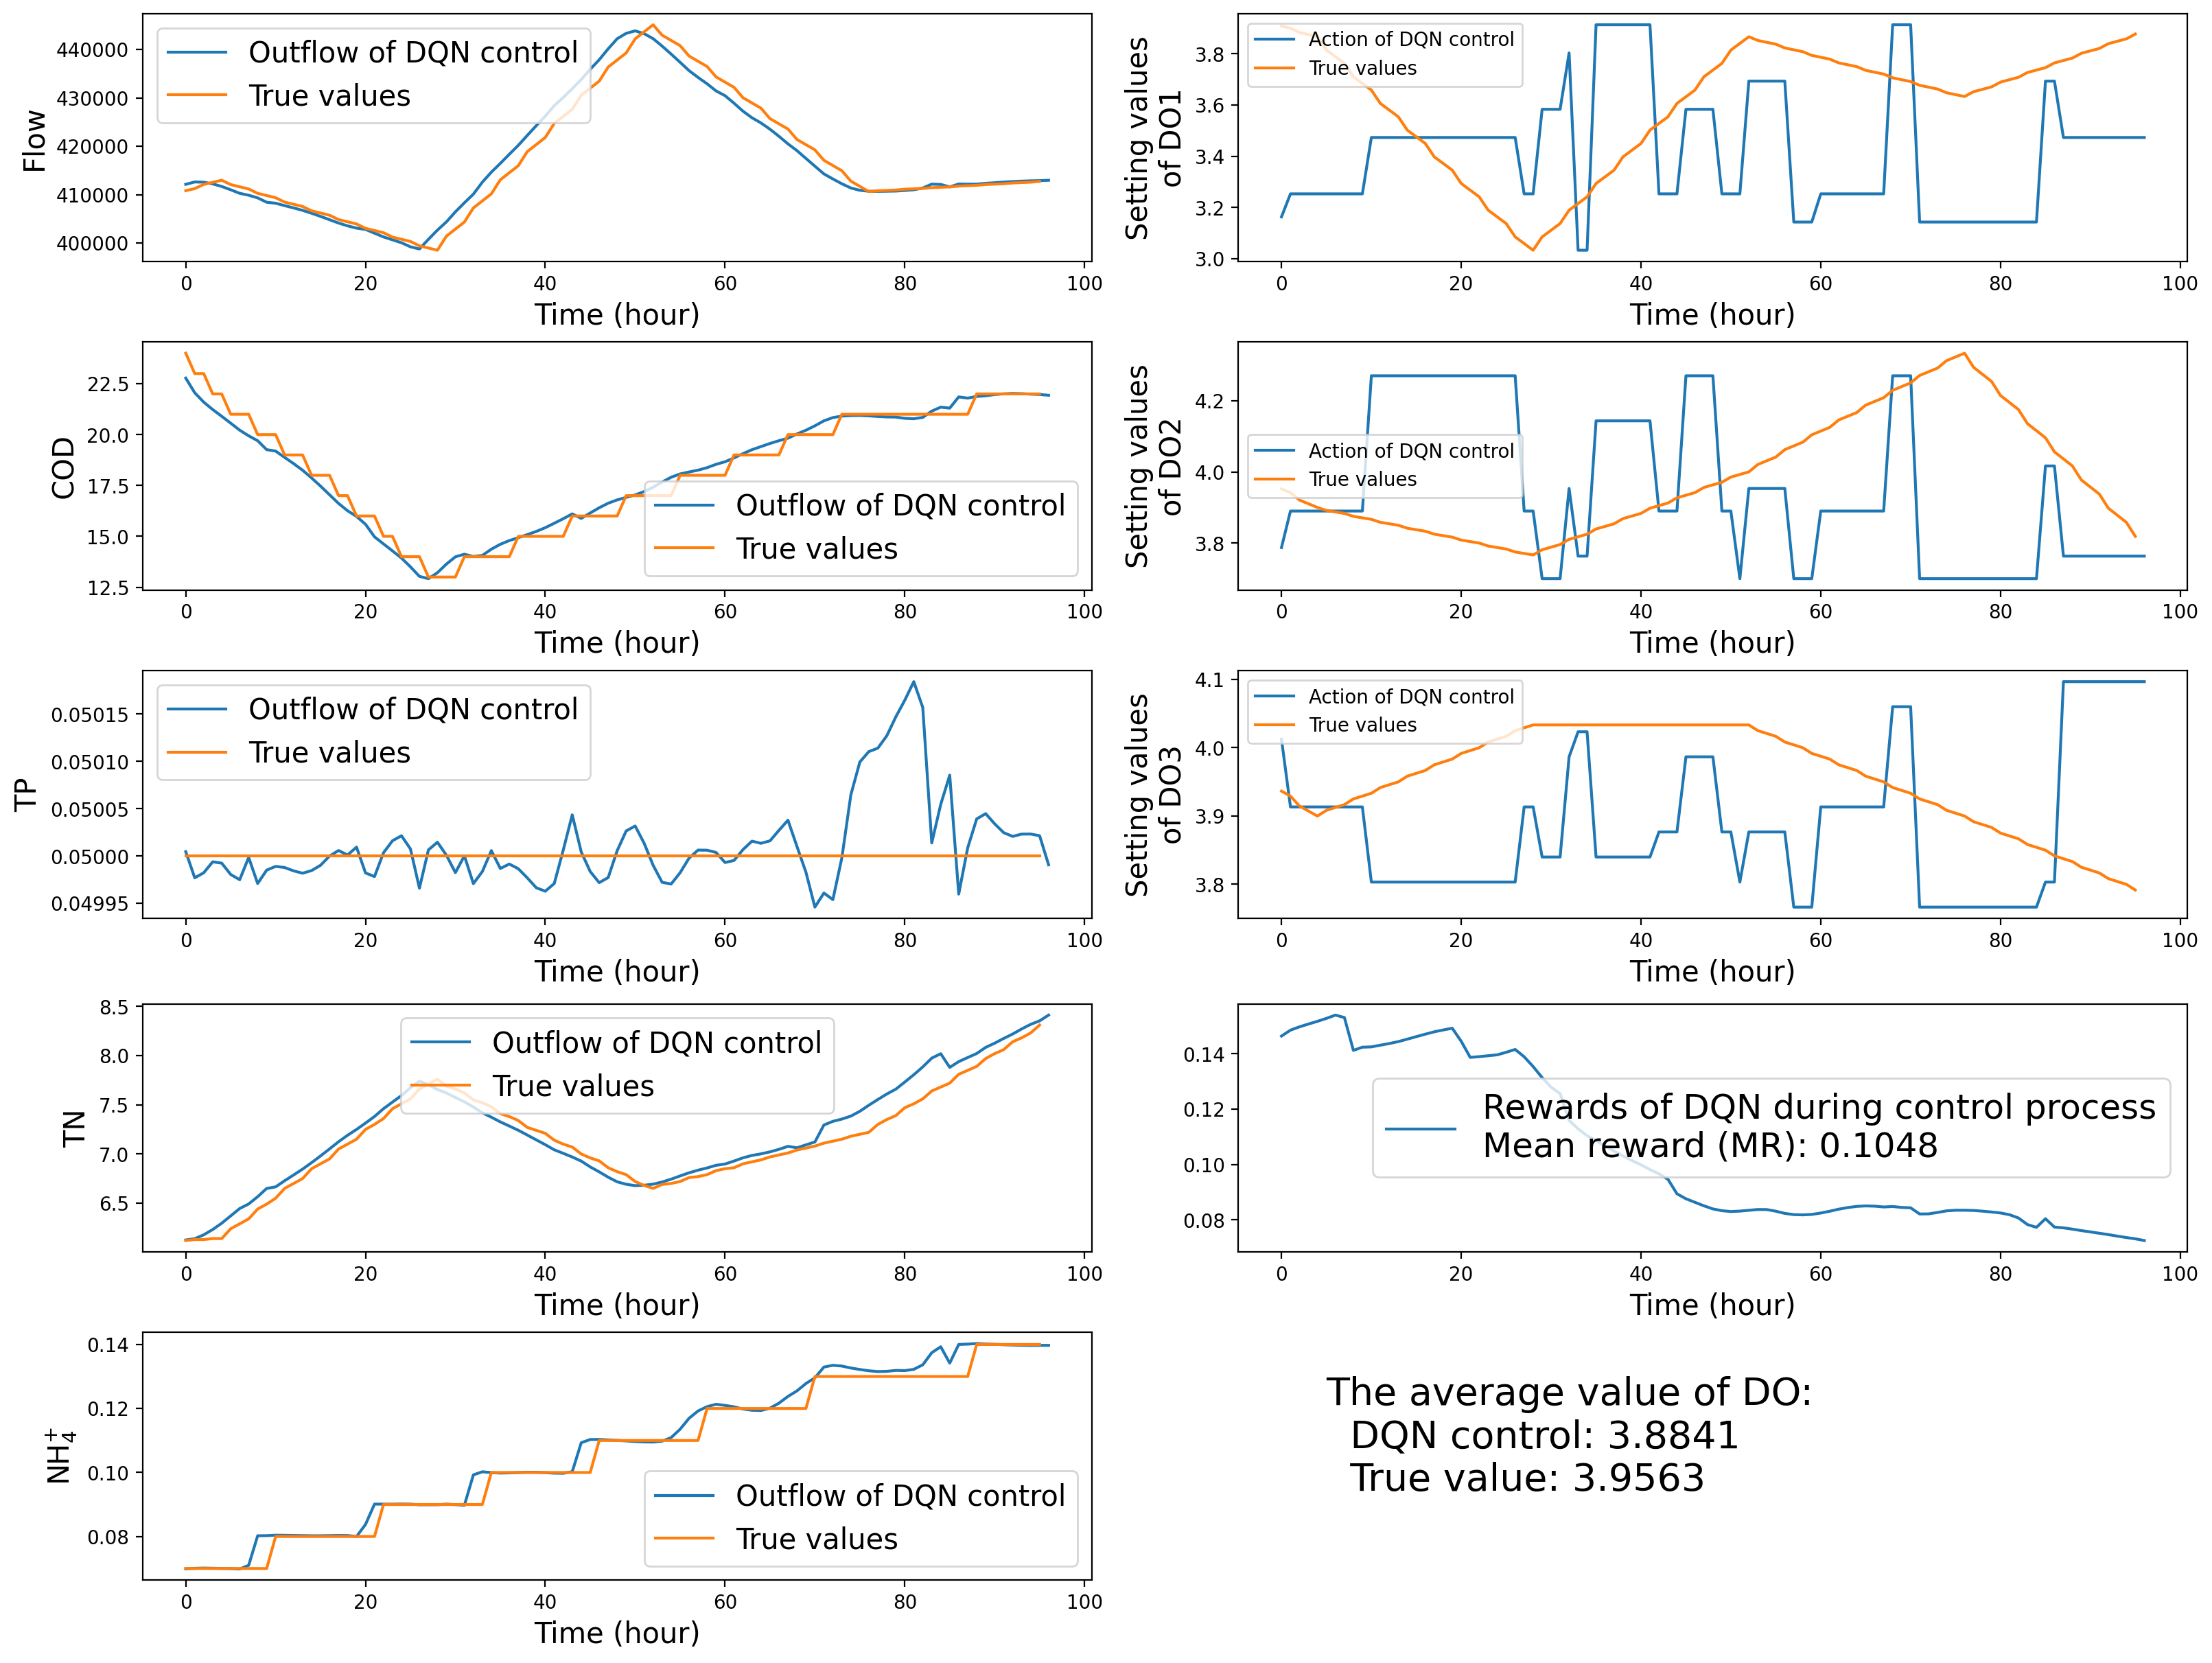

In [ ]:
fig = plt.figure(dpi=200, constrained_layout = True, figsize = (16,12))

gs = GridSpec(5,2, figure=fig)

# outflow
ylbel = ['Flow','COD','TP','TN','NH'+'$_{4}^{+}$']
for i in range(5):
    ax00 = fig.add_subplot(gs[i,0])
    ax00.plot(yre[:,i],label='Outflow of DQN control')
    ax00.plot(ytrainre[:,i],label='True values')
    ax00.set_ylabel(ylbel[i],fontsize=15)
    ax00.set_xlabel('Time (hour)',fontsize=15)
    ax00.legend(fontsize=15)

# action
albel = ['Setting values'+'\n'+'of DO1','Setting values'+'\n'+'of DO2','Setting values'+'\n'+'of DO3']
for i in range(3):
    ax00 = fig.add_subplot(gs[i,1])
    ax00.plot(are[:,i],label='Action of DQN control')
    ax00.plot(atrainre[:,i],label='True values')
    ax00.set_ylabel(albel[i],fontsize=15)
    ax00.set_xlabel('Time (hour)',fontsize=15)
    ax00.legend(fontsize=10)

fig.text(0.6,0.1,'The average value of DO:'+'\n'
         +'  '+'DQN control: ' + str(np.round(np.mean(are[:,i]),4)) +'\n'
         +'  '+'True value: '+ str(np.round(np.mean(atrainre[:,i]),4)),
         fontsize=20
         )

# reward
ax00 = fig.add_subplot(gs[3,1])
ax00.plot(reward,label='Rewards of DQN during control process'+'\n'+'Mean reward (MR): '+ str(np.round(np.mean(reward),3))+'(mg/L)')
ax00.set_xlabel('Time (hour)',fontsize=15)
ax00.legend(fontsize=18)

fig.savefig('control-oafig.png',dpi=200)